<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2018


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> Normalization </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> October 15 - 22, 2018</b></p>

<hr style='height:5px;border:none' />

# Brief introduction to Nipype
<hr style="height:1px;border:none" />

## Steps in fMRI data analysis

Although there are different software tools designed for fMRI data analysis, the steps required for such an analysis is very similar for the most part. 

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NeuroImageSchematic.png?raw=true' alt='fMRI processing steps'/>

Different software packages implements these steps to analyze fMRI data. So, in theory, it is possible to mix different steps from different software tools but you can still implement all the necessary steps.

## Why nipype?

Different fMRI analysis software tools have their own scripting capability. In other words, each package lets you write a script (a series of instructions) to implement the entire analysis pipeline from the beginning to the end. This is useful especially you have to run the same pre-processing and analysis steps for multiple subjects. Analyzing multiple subjects' data using a GUI will increase the risk of human error (clicking a wrong button, selecting a wrong file, entering wrong parameters, etc.). 

The syntax to script a processing pipeline is different in different packages. For a starter, in SPM you write a script in MATLAB, whereas in FSL, you need to code in a shell script. **Nipype** enables you to script different steps in different software tools in Python, so that mixing of different steps very easy.

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_WorkflowEg.png?raw=true' alt='Nipype workflow example'/>

Here is an example of how `nipype` implements different steps. The diagram such as this one represents a **workflow**, a series of tasks organized into a diagram, with output from one task fed into the following task. Here, each task is represented as a **node**. A node may take a certain input(s) and produces an output. 

# Preprocessing steps as objects
<hr style="height:1px;border:none" />

Now let's take a look as some simple steps in the data preprocessing as examples of how Nipype works. 

## Skull stripping (FSL)

As you can imagine from the name, skull stripping refers to a process of removing non-brain tissues (skulls, bones, soft tissues) from structural MRI data. This step is necessary for normalization in FSL (to be covered later), but not for SPM. Here is an example code to perform skull stripping in FSL.

`<SkullStrip_fsl.py>`

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions

# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# an T1 weighted image from one of the subjects
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w.nii.gz')

I shall use the ds102 data set for this example. In particular, subject 26.

Now, I create an object called **`mybet`**, a skull stripping process object with **`BET`** located under **`nipype.interfaces.fsl`**. 

In [5]:
# creating an object for BET process
mybet = fsl.BET()

Then I specify input and output file names as parameters for the BET object.

In [6]:
# output image file name
imageT1Out = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain.nii.gz')

# specifying the input and output file names in the BET object
mybet.inputs.in_file = imageT1
mybet.inputs.out_file = imageT1Out

Notice that the output file name has the suffix **`_brain`** attached to the input file name. At this point, you are ready to run skull stripping with the **`run()`** method associated with `mybet` object.

In [4]:
# running BET
mybet.run()

Let's see the results from skull stripping. For that, I am calling three functions that I have written, **`show_plane`**, **`show_section`**, and **`load_nii_data`**. They are located under the directory **`functions`**.

In [8]:
# Importing custom functions for displaying sections
import sys
sys.path.append('functions')
from DisplaySection import show_section, load_nii_data

If you are curious, these are the functions that are just imported. 

In [16]:
def show_plane(x):
    '''
    Function to show a slice (provided as a 2D array)
    '''
    plt.imshow(x, cmap="gray")
    plt.gca().set_axis_off()


def show_section(xImg, section, xSlice):
    '''
    Function to return a 2D array of a slice from a 3D array.
    Slice orientation can be specified by the user.
    '''
    if section=='xy':
        tmpImg = xImg[:,:,xSlice]
    elif section=='xz':
        tmpImg = xImg[:,xSlice,:]
    else:
        tmpImg = xImg[xSlice,:,:]
    show_plane(np.rot90(tmpImg))

def load_nii_data(f_nii):
    '''
    Functio to load an NIfTI image and returns the data matrix
    as an array.
    '''
    nii = nib.load(f_nii)
    X = nii.get_data()
    return X

Then displaying the original and skull-stripped images.

In [1]:
%matplotlib inline

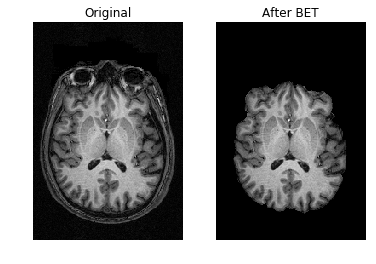

In [10]:
# loading the data matrices
X = load_nii_data(imageT1)
Xbet = load_nii_data(imageT1Out)

# showing the before and after images
plt.subplot(121)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(122)
show_section(Xbet, 'xy', 140)
plt.title('After BET')
plt.show()

One parameter you may possibly manipulate is the *fractional intensity threshold*. This parameter **`mybet.inputs.frac`** alters how laxed / strict about defining brain tissues. The default is 0.5. A smaller value includes a larger volume as the brain, and a larger value includes less volume as the brain. As a comparison, I re-run the skull stripping with `frac`=0.3 and 0.7.  

In [20]:
# playing with thresholds, then the output file
# first, threshold = 0.2
imageT1Out02 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain_f02.nii.gz')
mybet.inputs.frac = 0.2  # here, actually specifying the threshold
mybet.inputs.out_file = imageT1Out02
mybet.run()

# second, threshold = 0.8
imageT1Out08 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain_f08.nii.gz')
mybet.inputs.frac = 0.8  # here, actually specifying the threshold
mybet.inputs.out_file = imageT1Out08
mybet.run()

Let's compare the results.

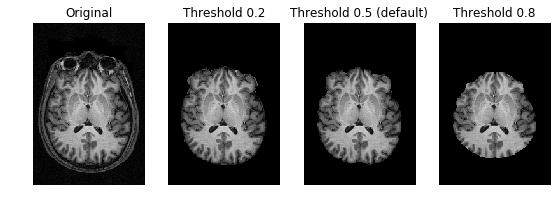

In [31]:
# showing the skull stripping with various parameters
plt.figure(figsize=[8,2.5])
# loading the data matrices
X = load_nii_data(imageT1)
Xbet02 = load_nii_data(imageT1Out02)
Xbet = load_nii_data(imageT1Out)
Xbet08 = load_nii_data(imageT1Out08)

# showing the before and after images
plt.subplot(141)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(142)
show_section(Xbet02, 'xy', 140)
plt.title('Threshold 0.2')
plt.subplot(143)
show_section(Xbet, 'xy', 140)
plt.title('Threshold 0.5 (default)')
plt.subplot(144)
show_section(Xbet08, 'xy', 140)
plt.title('Threshold 0.8')
plt.show()

## Segmentation

Segmentation often refers to the process of separating voxels (from T1-weighted images) into different tissue types: gray matter (GM), white matter (WM), and cerebrospinal fluid (CSF). This is accomplished by the intensity different between the different tissue types, and by modeling the voxel intensity distribution as a mixture of multiple distributions. 

### Segmentation with FSL

FSL requires that you have skull-stripped the T1-wighted image before segmentation. The actual segmentation can be implemented as a **`FAST`** object in **`nipype.interfaces.fsl`**. Here is an example. 

`<Segment_fsl.py>`

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# an T1 weighted image from one of the subjects, skull stripped
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w_brain.nii.gz')

Notice that the input image is the skull-stripped image I generated earlier.

Then I define **`fslFAST`**, an object for segmentation. 

In [33]:
# creating an object for FAST (segmentation) process
fslFAST = fsl.FAST()

Now, specifying the input and output. Here, the output is not a single image, but a collection of image. So I am providing the **`out_basename`**, the base for the output file names. To this base various suffices are added to denote different output images.

In [4]:
# output base name 
outBase = imageT1.replace('.gz','').replace('.nii','')

In [18]:
outBase

'/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/sub-26/anat/sub-26_T1w_brain'

In [36]:
# specifying the input and output file names in the FAST object
fslFAST.inputs.in_files = imageT1
fslFAST.inputs.out_basename = outBase

Finally, running the segmentation by the **`run()`** method associated with the segmentation object `fslFAST`. ***This process will likely take a few minutes, depending on how fast your computer is.***

In [45]:
# running FAST
fslFAST.run()

TraitError: The trait 'tissue_class_map' of a FASTOutputSpec instance is an existing file name, but the path  '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Notes/sub-26_T1w_brain_seg.nii.gz' does not exist.

You may see an error message here (like I did. Don't know why...). But as long as the output has been generated, I wouldn't worry too much about it.

In [19]:
os.listdir(os.path.split(outBase)[0])

['sub-26_T1w_brain_pve_1.nii.gz',
 'sub-26_T1w_brain_seg.nii.gz',
 'sub-26_T1w_brain_pveseg.nii.gz',
 'sub-26_T1w_brain.nii.gz',
 'sub-26_T1w_brain_mixeltype.nii.gz',
 'sub-26_T1w_brain_pve_2.nii.gz',
 'sub-26_T1w.nii.gz',
 'sub-26_T1w_brain_pve_0.nii.gz']

If you see image files with the suffix containing **`_pve`**, that means that segmentation was successful. Let's examine the results.

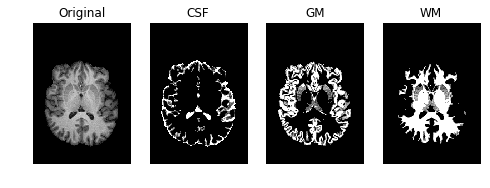

In [20]:

# loading the data matrices
X = load_nii_data(outBase+'.nii.gz')
Xseg0 = load_nii_data(outBase+'_pve_0.nii.gz')
Xseg1 = load_nii_data(outBase+'_pve_1.nii.gz')
Xseg2 = load_nii_data(outBase+'_pve_2.nii.gz')

# showing the before and after images
plt.figure(figsize=[8,3])
plt.subplot(141)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(142)
show_section(Xseg0, 'xy', 140)
plt.title('CSF')
plt.subplot(143)
show_section(Xseg1, 'xy', 140)
plt.title('GM')
plt.subplot(144)
show_section(Xseg2, 'xy', 140)
plt.title('WM')
plt.show()

In FSL,
  * Suffix: `_pve_0` -- CSF
  * Suffix: `_pve_1` -- Gray matter
  * Suffix: `_pve_2` -- White matter


In [5]:
# removing files created by this process
dirT1 = os.path.split(imageT1)[0]
listFiles = os.listdir(dirT1)
rmList = []
for iFile in listFiles:
    if '_brain_' in iFile:
        rmList.append(os.path.join(dirT1,iFile))
for jFile in rmList:
    os.unlink(jFile)

### Segmentation with SPM

SPM has its own segmentation process. It does not require the user to skull-strip the T1 weighted image. Here is the example code for segmentation with SPM.

`<Segment_spm.py>`

In [6]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype.algorithms.misc import Gunzip  # gunzip interface


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

In [7]:
# an T1 weighted image from one of the subjects
imageT1 = os.path.join(dataDir,'sub-26/anat/sub-26_T1w.nii.gz')

Here, the input NIfTI file is compressed (with **`.nii.gz`**). However, SPM cannot handle compressed NIfTI files, so I need to uncompress the image data with an **`Gunzip`** object defined under **`nipype.algorithms.misc`**.

In [8]:
# gunzip object
gunzip = Gunzip()

# unzipping the T1 image first
gunzip.inputs.in_file = imageT1
res = gunzip.run()

The uncompressed file is written to the current working directory. The path can be accessed by **`res.outputs.out_file`**.

In [6]:
res.outputs.out_file

'/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Notes/sub-26_T1w.nii'

Now let's create a segmentation object called **`spmSeg`**, as a **`NewSegment`** object in **`nipype.interfaces.spm`**. 

In [7]:
# creating an object for segmentation process
spmSeg = spm.NewSegment()

# specifying the input file in the segmentation object
spmSeg.inputs.channel_files = res.outputs.out_file

The input is the uncompressed file from earlier. Now we are ready to run the segmentation process with the **`run()`** method.

In [9]:
# running segmentation
spmSeg.run()

Like FSL's segmentation, SPM's segmentation generates a large number of files.

In [10]:
listFiles = os.listdir(os.getcwd())
listNii = [i for i in listFiles if 'nii' in i]
listNii

['c1sub-26_T1w.nii',
 'c2sub-26_T1w.nii',
 'c3sub-26_T1w.nii',
 'c4sub-26_T1w.nii',
 'c5sub-26_T1w.nii',
 'sub-26_T1w.nii']

We shall examine what they are.

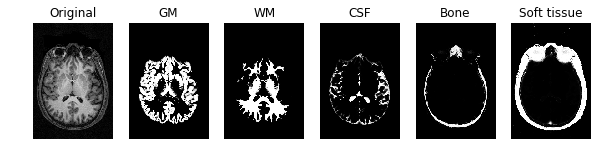

In [11]:
# Importing custom functions for displaying sections
import sys
sys.path.append('functions')
from DisplaySection import show_section, load_nii_data


# loading the data matrices
X = load_nii_data(res.outputs.out_file)
Xseg1 = load_nii_data(res.outputs.out_file.replace('sub','c1sub'))
Xseg2 = load_nii_data(res.outputs.out_file.replace('sub','c2sub'))
Xseg3 = load_nii_data(res.outputs.out_file.replace('sub','c3sub'))
Xseg4 = load_nii_data(res.outputs.out_file.replace('sub','c4sub'))
Xseg5 = load_nii_data(res.outputs.out_file.replace('sub','c5sub'))


# showing the before and after images
plt.figure(figsize=[10,2.5])
plt.subplot(161)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(162)
show_section(Xseg1, 'xy', 140)
plt.title('GM')
plt.subplot(163)
show_section(Xseg2, 'xy', 140)
plt.title('WM')
plt.subplot(164)
show_section(Xseg3, 'xy', 140)
plt.title('CSF')
plt.subplot(165)
show_section(Xseg4, 'xy', 140)
plt.title('Bone')
plt.subplot(166)
show_section(Xseg5, 'xy', 140)
plt.title('Soft tissue')
plt.show()

In SPM,
  * Prefix: `c1` -- Gray matter
  * Prefix: `c2` -- White matter
  * Prefix: `c3` -- CSF
  * Prefix: `c4` -- Bones
  * Prefix: `c5` -- Soft tissues

In [9]:
# removing files created by this process
listFiles = os.listdir('.')
rmList = []
for iFile in listFiles:
    if (('.nii' in iFile) or ('.m' in iFile)) and ('.md' not in iFile):
        rmList.append(iFile)
for jFile in rmList:
    os.unlink(jFile)

Just for curiosity, let's compare the segmentation results between FSL and SPM. First, gray matter.

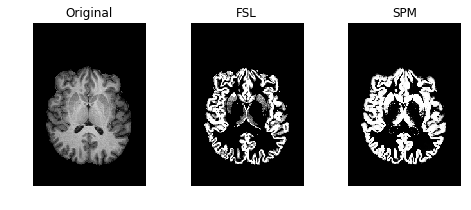

In [14]:
# loading the data matrices
X = load_nii_data(outBase+'.nii.gz')
Xfsl = load_nii_data(outBase+'_pve_1.nii.gz')
Xspm = load_nii_data(res.outputs.out_file.replace('sub','c1sub'))

# showing the before and after images, FSL and SPM
plt.figure(figsize=[8,3])
plt.subplot(131)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(132)
show_section(Xfsl, 'xy', 140)
plt.title('FSL')
plt.subplot(133)
show_section(Xspm, 'xy', 140)
plt.title('SPM')
plt.show()

White matter.

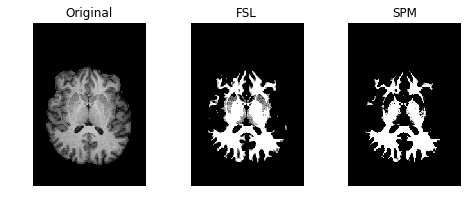

In [15]:
# loading the data matrices
X = load_nii_data(outBase+'.nii.gz')
Xfsl = load_nii_data(outBase+'_pve_2.nii.gz')
Xspm = load_nii_data(res.outputs.out_file.replace('sub','c2sub'))

# showing the before and after images, FSL and SPM
plt.figure(figsize=[8,3])
plt.subplot(131)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(132)
show_section(Xfsl, 'xy', 140)
plt.title('FSL')
plt.subplot(133)
show_section(Xspm, 'xy', 140)
plt.title('SPM')
plt.show()

And CSF.

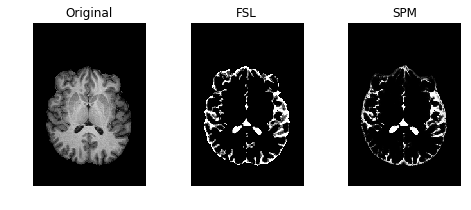

In [16]:
# loading the data matrices
X = load_nii_data(outBase+'.nii.gz')
Xfsl = load_nii_data(outBase+'_pve_0.nii.gz')
Xspm = load_nii_data(res.outputs.out_file.replace('sub','c3sub'))

# showing the before and after images, FSL and SPM
plt.figure(figsize=[8,3])
plt.subplot(131)
show_section(X, 'xy', 140)
plt.title('Original')
plt.subplot(132)
show_section(Xfsl, 'xy', 140)
plt.title('FSL')
plt.subplot(133)
show_section(Xspm, 'xy', 140)
plt.title('SPM')
plt.show()

# Normalization - Theory
<hr style="height:1px;border:none" />

## What is normalization?

As you can imagine, everybody's head has a different shape, thus everybody's brain is different. Consequently, comparing brains from multiple people can be challenging. One solution is to *warp* everybody's brain into the standard shape brain (often referred as the **template**) so that we can compare brains across subjects.

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_Concept.png?raw=true' alt='Idea of normalization'/>

Normalization is typically performed using a subject's structural MRI data. The warp from the subject's **native space** to the **template space** is often estimated.  

### Native and template spaces

What is a **native space**? This refers to the subject's original brain space ***before*** warping. Since voxel coordinates for particular anatomical landmarks are specific to each subject, native space coordinates are rarely reported. 

<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_NativeSpace.png?raw=true' alt='Native space'/>

What is the **template space**? This refers to, as you can imagine from the name, the space of the template image. Voxel coordinates from the template space are often reported in the literature since it is in the standard space. 

<img style='width: 400px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_TemplateSpace.png?raw=true' alt='Template space'/>

In the early days of brain imaging research (in the 90s and early 2000), people used the Talairach atlas (by Talairach & Tournoux, 1988) as the template. The Talairach atlas is defined based on a single post-mortem brain. Today, the MNI (Montreal Neurological Institute) template is most widely used. The MNI template is the average of 152 high resolution brain images (of young adults) warped with high-dimensional transformation to a common space. 

## How are images normalized

In many software packages, normalization is performed in two steps; a **linear** registration followed by a **non-linear** registration

### Linear registration

The goal of linear registration is to roughly match a subject's brain with the template brain. A linear registration consists of 4 different types of mathematical operations (translation, rotation, scaling, and shear) in 3 different directions (x-, y-, and z-directions). These transformations are often referred as the **affine transformation**. In total, there are 12 possible operations in an affine transformation, it can be described in a 3x4 matrix, known as an *affine matrix*.

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_Linear.png?raw=true' alt='Linear registration'/>


A linear registration is applied to the entire image, without any local refinement.

### Non-linear registration

The goal of non-linear registration is to warp an image locally to match the template as much as possible. Since non-linear registration is performed locally, a very large number of parameters are needed to describe such a transformation. A sophisticate non-linear registration algorithm requires significant computational resources (like, a super-computer) and hours of calculation. Algorithms used by fMRI analysis packages are much less sophisticated, and can be run on a decent work station in 30 min or less. However, even such simple algorithms require thousands of parameters.

<img style='width: 450px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_NonLinear.png?raw=true' alt='Non-linear registration'/>


## Additional details on normalization

### Bias field

It is often the case that the intensity in a T1-weighted image is not uniform even for the same tissue types. Such inhomogeneity in intensity is corrected by the bias field correction. 

<img style='width: 500px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_BiasField.png?raw=true' alt='Non-linear registration'/>

Bias field correction is often a part of normalization process, and automatically done in FSL and SPM.

### Cost fuction and regularization parameter

In many model-based optimization problems (e.g., generalized linear model), model parameters are often found by optimizing (i.e., producing the smallest value) a function of the form:

$$
arg\min_{\pmb{\beta}} \left \{ d\left(\pmb{Y}, \hat{\pmb{Y}}(\pmb{X}, \pmb{\beta}) \right)
+ \lambda \left\Vert \pmb{\beta} \right\Vert \right \}
$$

Here,
  * $\pmb{Y}$: The data to be modeled
  * $\pmb{\beta}$: parameters to be estimated
  * $\pmb{X}$: The covariates to predict the data
  * $\hat{\pmb{Y}}(\pmb{X}, \pmb{\beta})$: The prediction based on the model. A function of $\pmb{X}$ and $\pmb{\beta}$.

The function $d(\cdot)$ is known as a **cost function**. It measures how similar / different two data sets are. A small value of the cost function indicates that the two data sets are similar, while a large value of the cost function indicates that two data sets differ. A simple example of a cost function is the sum of squared difference:
$$
d \left(\pmb{Y}, \hat{\pmb{Y}} \right) = \left\Vert \pmb{Y} - \hat{\pmb{Y}} \right\Vert ^2
$$
Two types of cost functions predominantly used on neuroimaging data are:
  * **Intensity difference**: As the name suggests, the squared sum of the voxel intensity differences between two images. Useful in comparing images of the same modality (thus similar intensity scales).
  * **Entropy / mutual information**: How dependent voxel intensity distributions are between two images. Useful in comparing images with different modalities (e.g., comparing a T1-weighted image and a T2-weighted image).
  
 
The second term in the optimization formula is $\lambda \left\Vert \pmb{\beta} \right\Vert$, also known as **regularization**. This term ensures that the model parameters $\pmb{\beta}$ are as small as possible. Large values of $\pmb{\beta}$ penalizes the optimization process. The parameter $\lambda$ is known as Lagrange's multiplier, or a **regularization parameter**. A large value of $\lambda$ (i.e., strong regularization) ensures that there is no *extreme bending* during the non-linear warping process. If the regularization parameter is too small, then the model may be *over-fitting* with some severe bending.
  
<img style='width: 500px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Normalization_Regularization.png?raw=true' alt='Regularization examples'/>

In a typical normalization process with SPM or FSL, you may be able to choose a cost function, as well as the level of regularization as parameters in normalization. Often the default values would be sufficient, but if normalization fails for some subjects, then you may consider the choices for these options.

# Normalization with Nipype
<hr style="height:1px;border:none" />

## Nodes and workflows in Nipype
In Nipype, you can combine multiple data processing steps as a **workflow**. Each processing step in a workflow is referred as a **node**. A node in Nipype is often a *wrapper* function, a function that calls another function. Unlike a code for pre-processing steps as seen above, a node is a self-contained process, with inputs from the previous node (if any) and outputs to be used in subsequent process(es). Thus nodes can be easily combined with other nodes to form a workflow.

Available nodes in Nipype depends on what software packages are installed on your computer. If you have SPM and FSL, then you can use preprocessing steps in either packages as a node. On the other hand, if you only have FSL installed on your computer, then Nipype cannot call an SPM node since SPM doesn't exist on your computer.

Here, I will demonstrate normalization in FSL and SPM, both as workflows, since spatial normalization often requires some preparatory steps.

## Normalization with FSL
Normalization with FSL requires 3 steps: skull-stripping, linear normalization, and non-linear normalization.


`<Norm_fsl.py>`

In [1]:
import os
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an T1 weighted image from one of the subjects
imageT1 = layout.get(subject='26', 
                     type='T1w', 
                     extensions='nii.gz',
                     return_type='file')[0]

# template image (from FSL)
fMNI = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')


Here, I am defining 
  * the data directory **`dataDir`**
  * the T1-weighted image to be used (**`imageT1`**) 
  * the template image defining the template space (**`fMNI`**, FSL's template for the MNI space)
  * the output directory **`outDir`**

The location of these files / directories may need to be altered, depending on the computer you are using.

In [2]:
# Skullstrip process node
fslBET = Node(fsl.BET(in_file=imageT1), 
              name="fslBET")

Here is the first node. The **`Node`** object is defined in **`nipype`** library. It takes a process (in this case **`fsl.BET`**) along with some parameters. In this case, the input file **`in_file`** is the only parameter to be used. I name this node **`fslBET`**. Now let's define the linear and non-linear normalization nodes as well.

In [3]:
# Linear normalization node
fslFLIRT = Node(fsl.FLIRT(reference=fMNI,
                          cost_func='normmi'),
                name="fslFLIRT")

# Non-linear normalization node
fslFNIRT = Node(fsl.FNIRT(ref_file=fMNI),
                name='fslFNIRT')

For the linear normalization process, I use **`fsl.FLIRT`**. For the non-linear normalization process, I use **`fsl.FNIRT`**. I name them `fslFLIRT` and `fslFNIRT`, respectively. Both processes require **`reference`**, the template image, as the input parameter. In addition, for `fslFLIRT`, I specify the cost function **`cost_func`** parameter as **`'normmi'`** or normalized mutual information.

Now all the nodes are defined, so I combine them as a workflow and *connect* them in the order of the normalization process. First, I define a workflow object **`Workflow`** available in **`nipype`**. 

In [4]:
# Creating a workflow object
wf = Workflow(name="fslNorm", base_dir=outDir)

Here, a workflow object **`wf`** is created. I give it a name **`fslNorm`**. This will be the directory name under the parameter **`base_dir`** where all the outputs are written to. Now I add nodes to this workflow by connecting inputs/outputs from nodes by the **`connect`** method for the workflow object `wf`.

In [5]:
# connecting nodes as a workflow
wf.connect(fslBET, "out_file", fslFLIRT, "in_file")

Here, nodes `fslBET` and `fslFLIRT` are connected. The output from `fslBET`, **`out_file`**, is used as the input to `fslFLIRT`, **`in_file`**. The names of these inputs / outputs are defined in `nipype`. The best way to find out is by examining the help document for the corresponding processes. For example,

In [6]:
fsl.BET.help()

Wraps command **bet**

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to skull strip
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	center: (a list of at most 3 items which are an integer (int or
		 long))
		center of gravity in voxels
		flag: -c %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	frac: (a float)
		

shows a list of inputs and outputs for `fsl.BET`. 

The `.connect` method for a work flow in the above notation is useful if two nodes are connected, and a single output is passed on as a single input. If inputs from multiple nodes are required, or multiple outputs have to be passed on, then then following notation of `connect` method is more useful.

In [6]:
wf.connect([(fslBET, fslFNIRT, [('out_file', 'in_file')]),
            (fslFLIRT,fslFNIRT, [('out_matrix_file', 'affine_file')])])

Here, we have:
  * `out_file` from `fslBET` is used as `in_file` in `fslFNIRT`
  * `out_matrix_file` from `fslFLIRT` is used as `affine_file` in `fslFNIRT`
  
Now all the workflow is defined. We can visualize the workflow by **`write_graph`** method associated with a workflow object `wf`.

In [7]:
# writing out graphs
wf.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

181026-13:39:24,320 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/graph_orig.png (graph2use=orig, simple_form=True).


'/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/graph_orig.png'

Here is what the workflow looks like:

<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NormFSL_graph.png?raw=true' alt='FSL Normalization workflow'/>

Or with more details, showing inputs and outputs:

<img style='width: 500px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NormFSL_graph_detailed.png?raw=true' alt='FSL normalization workflow, detailed'/>

### Datasink

One advantage of using Nipype is that it doesn't clutter your computer with many intermediate files typically generated by FSL or SPM. However, you may be interested in some of those intermediate outputs. Say, you are interested in a linear-normalized image from `fslFLIRT`. However, such image is not used as the input or output for any of the processes in the workflow, so it is not saved by default. If you want to save some intermediate data, then you can output it to a *dummy* node known as a **data sink**. A **`DataSink`** object is available in **`nipype.interfaces.io`**. Here is how you can define a data sink object under the output directory `outDir`. 

In [8]:
# DataSink to collect intermediate outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

Output images from `fslFLIRT` (more specifically, **`'out_file'`** or linear-normalized image) and `fslFNIRT` (**`'warped_file'`** or linear & non-linear normalized image) are written to the data sink. 

In [9]:
# adding datasink
wf.connect(fslFLIRT, 'out_file', datasink, 'NormFSL.@flirt')
wf.connect(fslFNIRT, 'warped_file', datasink, 'NormFSL.@fnirt')

Here, **`'NormFSL.@flirt'`** means it will write the output data to the directory **`NormFSL`** under the output base directory `outDir` (defined earlier). **`.@flirt`** doesn't have any influence on the output file name. This is a trick necessary when you want to output multiple files to the same directory. This string has to start with **`.@`** and the string has to be different from other data

Just for fun, let's take a look at the workflow diagram with the data sink.

In [11]:
# writing out graphs
wf.write_graph(graph2use='orig', dotfilename='graph_orig_datasink.dot')

181019-23:26:24,771 nipype.workflow INFO:
	 Generated workflow graph: /Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/graph_orig_datasink.png (graph2use=orig, simple_form=True).


'/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/graph_orig_datasink.png'

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NormFSL_graph_datasink.png?raw=true' alt='FSL normalization workflow, detailed, with data sink'/>

Now all the nodes, as well as the workflow are set up. All you need to do is to ***run*** the workflow with the **`run`** method associated with `wf`.

***Warning: It may take a long time (5+ minutes), depending on your computer.***

In [10]:
# running the workflow
wf.run()

181026-13:39:38,527 nipype.workflow INFO:
	 Workflow fslNorm settings: ['check', 'execution', 'logging', 'monitoring']
181026-13:39:38,535 nipype.workflow INFO:
	 Running serially.
181026-13:39:38,536 nipype.workflow INFO:
	 [Node] Setting-up "fslNorm.fslBET" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/fslBET".
181026-13:39:38,557 nipype.workflow INFO:
	 [Node] Cached "fslNorm.fslBET" - collecting precomputed outputs
181026-13:39:38,560 nipype.workflow INFO:
	 [Node] "fslNorm.fslBET" found cached.
181026-13:39:38,562 nipype.workflow INFO:
	 [Node] Setting-up "fslNorm.fslFLIRT" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/fslNorm/fslFLIRT".
181026-13:39:38,629 nipype.workflow INFO:
	 [Node] Cached "fslNorm.fslFLIRT" - collecting precomputed outputs
181026-13:39:38,630 nipype.workflow INFO:
	 [Node] "fslNorm.fslFLIRT" found cached.
181026-13:39:38,630 nipype.workflow INFO:
	 [Node] Setting-up "fslNorm.fslFNIRT" in "/home/satoru/Teachin

***Examining resulting images***

  * Original T1-weighted
  * Linear normalized
  * Linear & non-linear normalized

## Normalization with SPM

Normalization with SPM can be accomplished in a single step, **`spm.Normalize12`**. However, SPM does not take compressed NIfTI files (i.e., `.nii.gz`), so we need to unzip image files before normalizing. Moreover, we want to compare the normalized image from SPM with that of FSL. So we need to re-slice at the same voxel size as the FSL normalized image.

`<Norm_spm.py>`

In [11]:
import os
import nipype.interfaces.spm as spm # importing SPM interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms.misc import Gunzip  # gunzip interface
from bids.grabbids import BIDSLayout  # BIDSLayout object to specify file(s)


# Directory where your data set resides. This needs to be customized
dataDir = '/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102'
#dataDir = '/Users/sh45474/Documents/Teaching/fMRI_Fall_2018/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# an T1 weighted image from one of the subjects
imageT1 = layout.get(subject='26', 
                     type='T1w', 
                     extensions='nii.gz',
                     return_type='file')[0]

# template (it has to be tissue probability maps)
#fTPM = '/Users/sh45474/SoftwareTools/spm12/tpm/TPM.nii'
fTPM = '/usr/local/spm12/tpm/TPM.nii'

# fsl template (used for overlay)
fMNI = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

Here, I specify files and directories. One difference between FSL and SPM is that SPM requires a template images consisting of tissue probability maps (TPM). This is because SPM's normalization algorithm is designed to spatially warp tissues of different types to their respective templates in the MNI space.

Here are nodes for `gunzip` (i.e., unzipping) for the T1-weighted data, as well as for FSL's template image.

In [12]:
# gunzip node
gunzip = Node(Gunzip(in_file=imageT1),
              name="gunzip")

# gunzip fsl template
gunzipMNI = Node(Gunzip(in_file=fMNI),
                 name="gunzipMNI")

Here is the normalization node with **`spm.Normalize12`**.

In [13]:
# Normalize - normalizes structural images to the MNI template
normalize = Node(spm.Normalize12(jobtype='estwrite',
                                 tpm=fTPM,
                                 write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

I specify parameters:
  * Type of normalization job **`jobtype='estwrite'`** or estimate normalization parameter and write a normalized image
  * Template tissue probability map **`tpm=fTPM`**
  * The output voxel size **`write_voxel_sizes=[1, 1, 1]`**

It is not a necessary step, but I am re-slicing the normalized image to the same voxel size as the FSL template, so that I can display overlays easily (I will show this later).

In [14]:
# Reslice to the FSL template space
reslice = Node(spm.utils.Reslice(),
               name='reslice')

Also, a data sink to collect intermediate outputs of interest.

In [15]:
# DataSink to collect intermediate outputs
datasink = Node(DataSink(base_directory=outDir), 
                name='datasink')

All the nodes are connected.

In [16]:
# Creating a workflow object
spmNorm = Workflow(name="spmNorm", base_dir=outDir)

# connections between nodes
spmNorm.connect([(gunzip, normalize, [('out_file', 'image_to_align')])])
spmNorm.connect([(normalize, datasink, [('normalized_image', 'NormSPM')])])
spmNorm.connect([(gunzipMNI, reslice, [('out_file', 'space_defining')]),
                 (normalize, reslice, [('normalized_image', 'in_file')])])
spmNorm.connect([(reslice, datasink, [('out_file', 'NormSPM.@resliced')])])

# writing out graphs
spmNorm.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

181026-13:40:52,194 nipype.workflow INFO:
	 Generated workflow graph: /home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/spmNorm/graph_orig.png (graph2use=orig, simple_form=True).


'/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/spmNorm/graph_orig.png'

Here is the workflow diagram.

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_NormSPM_graph_detailed.png?raw=true' alt='SPM normalization workflow, detailed, with data sink'/>

Now I can run the entire process.

In [17]:
# running normalization
spmNorm.run()                               

181026-13:40:55,600 nipype.workflow INFO:
	 Workflow spmNorm settings: ['check', 'execution', 'logging', 'monitoring']
181026-13:40:55,614 nipype.workflow INFO:
	 Running serially.
181026-13:40:55,616 nipype.workflow INFO:
	 [Node] Setting-up "spmNorm.gunzipMNI" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/spmNorm/gunzipMNI".
181026-13:40:55,620 nipype.workflow INFO:
	 [Node] Cached "spmNorm.gunzipMNI" - collecting precomputed outputs
181026-13:40:55,621 nipype.workflow INFO:
	 [Node] "spmNorm.gunzipMNI" found cached.
181026-13:40:55,622 nipype.workflow INFO:
	 [Node] Setting-up "spmNorm.gunzip" in "/home/satoru/Teaching/fMRI_Fall_2018/Data/ds102/WorkflowOutput/spmNorm/gunzip".
181026-13:40:55,626 nipype.workflow INFO:
	 [Node] Cached "spmNorm.gunzip" - collecting precomputed outputs
181026-13:40:55,627 nipype.workflow INFO:
	 [Node] "spmNorm.gunzip" found cached.
181026-13:40:55,629 nipype.workflow INFO:
	 [Node] Setting-up "spmNorm.normalize" in "/home/satoru/Te

***Examining resulting images***

  * Original T1-weighted image
  * Normalized image

## Comparing FSL and SPM normalizations

***Comparing normalized images***
  * SPM normalized, resliced, with FSL template overlaid
  * FSL template with FSL normalized overlaid

You notice that normalization did not work well with FSL. This is likely because the skull striping process eliminated some brain voxels. One possible solution for this problem is to use a smaller threshold value for the `fslBET` step.


## Quality of normalization
There is not quantitative metric to quantify the quality of normalization. The quality of normalization is typically examined by humans. This is done by comparing the outlines of the normalized brain to the outline of the template brain. Also, some major anatomical landmarks may be compared (e.g., particular gyri, sulci, etc.).

If the quality of normalization is deemed sub-optimal, there are several approaches to improve normalization. The following is not an exhaustive list of possible solutions. Rather, somewhat common remedies for improved normalization.

  * Make sure that the native T1-weighted image is close to the template in terms of the location and the orientation.
     * Make a manual adjustment of the placement of the data.
  * Include more non-brain tissues (see Exercise below)
  * Increase regularization. This is a good solution when you see some extreme warping in the normalized image.
 

### Exercise

**1. Adjusting parameters**

1a. **Adjusting BET parameter** (FSL users). Construct another normalization workflow with the `fsl.BET` node with the parameter **`frac=0.2`**, so that more brain tissue is included in the skull striped brain. Post the code for the `fslBET` node on Canvas. How does this affect the quality of normalization?

1b. **Adjusting the bounding box** (SPM users). Construct another normalization workflow with the `spm.Normalize12` node with the parameter **`write_bounding_box=[[-90, -120, -70], [90, 90, 105]]`**. This is to expand the bounding box (the box around the head where normalization is applied). Post the code for the `spm.Normalize12` node on Canvas. Do you notice any difference in the output image from the normalization?

**2. Segmentation workflow**

2a. **Segmentation workflow (FSL)** (FSL users). Construct a workflow for tissue segmentation in FSL. The workflow should include at least an `fsl.BET` node and an `fsl.FAST` node. You may add a data sink if necessary. Post the code on Canvas.

2b. **Segmentation workflow (SPM)** (SPM users). Construct a workflow for tissue segmentation in SPM. The workflow should include at a node for `gunzip` and another node for `spm.NewSegment` node. You may add a data sink if necessary. Post the code on Canvas.
